# Data Ingestion EDA

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
main_file_path = r"../data/raw/nyra_2019_complete.parquet"
horse_global_ids = r"../data/raw/horse_ids.csv"
horse_names = r"../data/raw/horse_names.csv"

df = pd.read_parquet(main_file_path)

df_horse_ids = pd.read_csv(horse_global_ids, 
                           header=0,
                           index_col=0)
                           
df_horse_names = pd.read_csv(horse_names,
                             header=0,
                             index_col=0)

In [4]:
print("Tracking dataframe shape: ", df.shape)
print("Horse IDs dataframe shape: ", df_horse_ids.shape)
print("Horse names dataframe shape: ", df_horse_names.shape)

Tracking dataframe shape:  (5228429, 18)
Horse IDs dataframe shape:  (14916, 6)
Horse names dataframe shape:  (4638, 2)


In [5]:
print("Unique horse IDs:", df_horse_ids["horse_id"].nunique())
print("Unique horse Names:", df_horse_names["horse_name"].nunique())

Unique horse IDs: 4638
Unique horse Names: 4638


## Data Preprocessing

- Add column names
- Remove unnecessary rows (hurdles, measurements after finish line etc)
- Add global horse ID and names
- Purse feature is missing from race table

In [6]:
df.columns = ['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish']
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,65,40.672596,-73.827742,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


In [7]:
# program number 3 characters with whitespace or strings

df["program_number"] = df["program_number"].apply(lambda x: str(x).rstrip())
df["program_number"].unique()

array(['6', '2', '9', '3', '1', '11', '5', '4', '10', '7', '1A', '8',
       '13', '2B', '12', '14', '15', '16', '3X', '1X'], dtype=object)

Create primary key: `horse_pk` = `track_id`+`race_date`+`race_number`+`program_number`

In [8]:
df["horse_pk"] = df.apply(lambda x: f"{x["track_id"]}_{x["race_date"]}_{x["race_number"]}_{x["program_number"]}", axis=1)
df["horse_pk"].head()

0    AQU_2019-01-01_9_6
1    AQU_2019-01-01_9_6
2    AQU_2019-01-01_9_6
3    AQU_2019-01-01_9_6
4    AQU_2019-01-01_9_6
Name: horse_pk, dtype: object

In [9]:
df["win"] = np.where(df["position_at_finish"] == 1, 1, 0)

`rid` = `track_id`+`race_date`+`race_number`

In [10]:
# add unique race_id (rid)
df["rid"] = df.apply(lambda x: f"{x["track_id"]}_{x["race_date"]}_{x["race_number"]}", axis=1)
df["rid"].head()


0    AQU_2019-01-01_9
1    AQU_2019-01-01_9
2    AQU_2019-01-01_9
3    AQU_2019-01-01_9
4    AQU_2019-01-01_9
Name: rid, dtype: object

**Add global horse id's and horse names to main df**

- First need to create primary key for the merge
- Remove whitespaces from `horse_id` in `df_horse_ids` and convert to str

In [11]:
df_horse_ids["horse_pk"] = df_horse_ids.apply(lambda x: f"{x["track_id"]}_{x["race_date"]}_{x["race"]}_{x["program_number"]}", axis=1)
df_horse_ids["horse_pk"].head()

0    AQU_2019-01-01_1_5
1    AQU_2019-01-01_1_1
2    AQU_2019-01-01_1_2
3    AQU_2019-01-01_1_3
4    AQU_2019-01-01_1_4
Name: horse_pk, dtype: object

In [12]:
df_horse_ids["horse_id"] = df_horse_ids["horse_id"].astype(str).str.rstrip()
df_horse_ids["horse_id"].unique()

array(['0', '1', '2', ..., '4635', '4636', '4637'],
      shape=(4638,), dtype=object)

In [13]:
df = df.merge(df_horse_ids[["horse_pk", "horse_id"]], on="horse_pk", how="left")
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,purse,post_time,weight_carried,jockey,odds,position_at_finish,horse_pk,win,rid,horse_id
0,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,...,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60
1,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,...,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60
2,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,...,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60
3,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,...,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60
4,AQU,2019-01-01,9,6,65,40.672596,-73.827742,600,D,GD,...,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60


In [14]:
df_horse_names["horse_id"] = df_horse_names["horse_id"].astype(str).str.rstrip()
df_horse_names["horse_id"].unique()

array(['0', '1', '2', ..., '4635', '4636', '4637'],
      shape=(4638,), dtype=object)

In [15]:
df = df.merge(df_horse_names[["horse_id","horse_name"]], on="horse_id", how="left")
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,post_time,weight_carried,jockey,odds,position_at_finish,horse_pk,win,rid,horse_id,horse_name
0,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,...,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
1,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,...,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
2,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,...,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
3,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,...,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
4,AQU,2019-01-01,9,6,65,40.672596,-73.827742,600,D,GD,...,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde


## EDA

**Table reading example**
- Data structure for one race
- Data structure for one horse per race

In [16]:
example = df[df["rid"] == "AQU_2019-01-01_9"]
example = example.groupby("horse_id").first().reset_index()

example[["horse_id", "win", "jockey", "program_number", "rid", "position_at_finish"]].head(20)

,horse_id,win,jockey,program_number,rid,position_at_finish
0,53,1,Benjamin Hernandez,3,AQU_2019-01-01_9,1
1,54,0,Luis R. Reyes,10,AQU_2019-01-01_9,2
2,55,0,Reylu Gutierrez,8,AQU_2019-01-01_9,3
3,56,0,Rajiv Maragh,11,AQU_2019-01-01_9,4
4,57,0,Joey R. Martinez,9,AQU_2019-01-01_9,5
5,58,0,Joel Sone,4,AQU_2019-01-01_9,6
6,59,0,Manuel Franco,7,AQU_2019-01-01_9,7
7,60,0,Andre Shivnarine Worrie,6,AQU_2019-01-01_9,8
8,61,0,Harry Hernandez,1,AQU_2019-01-01_9,9


In [17]:
winner_horse = df[(df["rid"] == "AQU_2019-01-01_9") & (df["win"] == 1)].sort_values("trakus_index")
winner_horse

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,post_time,weight_carried,jockey,odds,position_at_finish,horse_pk,win,rid,horse_id,horse_name
166220,AQU,2019-01-01,9,3,1,40.670228,-73.828809,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166221,AQU,2019-01-01,9,3,2,40.670231,-73.828807,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166210,AQU,2019-01-01,9,3,3,40.670234,-73.828804,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166211,AQU,2019-01-01,9,3,4,40.670238,-73.828801,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166212,AQU,2019-01-01,9,3,5,40.670247,-73.828797,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166227,AQU,2019-01-01,9,3,293,40.670862,-73.832243,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166216,AQU,2019-01-01,9,3,294,40.670831,-73.832256,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166217,AQU,2019-01-01,9,3,295,40.670799,-73.832270,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright
166218,AQU,2019-01-01,9,3,296,40.670767,-73.832283,600,D,GD,...,420,113,Benjamin Hernandez,110,1,AQU_2019-01-01_9_3,1,AQU_2019-01-01_9,53,Alright Alright


In [ ]:
# how many races ("rid") does each horse run (horse_id)

races_per_horse = df.groupby("horse_id")["rid"].nunique().reset_index()
races_per_horse.sort_values("rid", ascending=False)

,horse_id,rid
3358,402,21
233,1207,20
4631,993,19
1180,206,18
1535,238,17
4197,601,17
4102,516,17
635,157,17
4594,96,17
2090,288,16


In [31]:
races_per_horse["rid"].describe()

count    4638.000000
mean        3.215826
std         2.706033
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        21.000000
Name: rid, dtype: float64

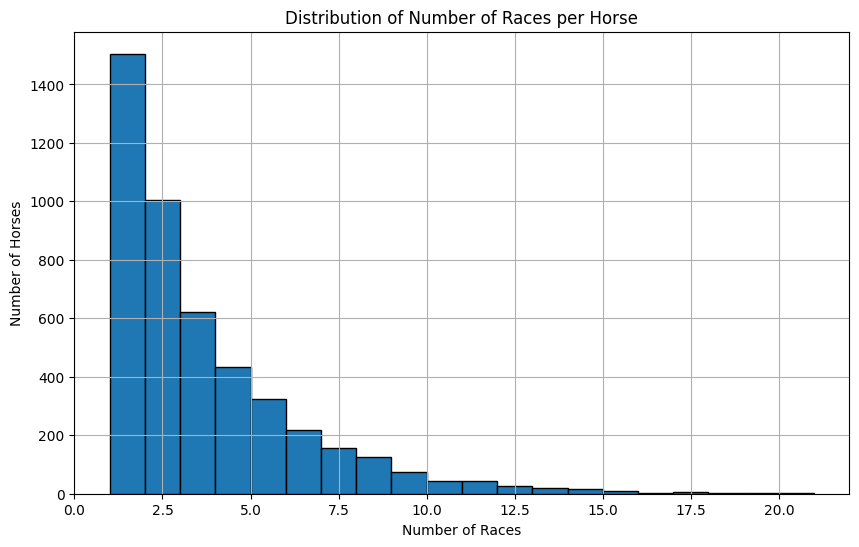

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(races_per_horse["rid"], bins=20, edgecolor='black')
plt.title("Distribution of Number of Races per Horse")
plt.xlabel("Number of Races")
plt.ylabel("Number of Horses")
plt.grid(True)
plt.show()

In [32]:
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish,horse_pk,win,rid,horse_id,horse_name
0,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
1,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
2,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
3,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde
4,AQU,2019-01-01,9,6,65,40.672596,-73.827742,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8,AQU_2019-01-01_9_6,0,AQU_2019-01-01_9,60,Crafty Concorde


In [33]:
races_per_jockey = df.groupby("jockey")["rid"].nunique().reset_index()
races_per_jockey.sort_values("rid", ascending=False)

,jockey,rid
119,Manuel Franco,1274
42,Dylan Davis,1108
96,Jose Lezcano,990
103,Junior Alvarado,852
66,Irad Ortiz Jr.,802
50,Eric Cancel,721
106,Kendrick Carmouche,714
95,Jose L. Ortiz,702
118,Luis Saez,666
77,Joel Rosario,657


In [34]:
df["jockey"].nunique()

178

Text(0, 0.5, 'Number of Jockeys')

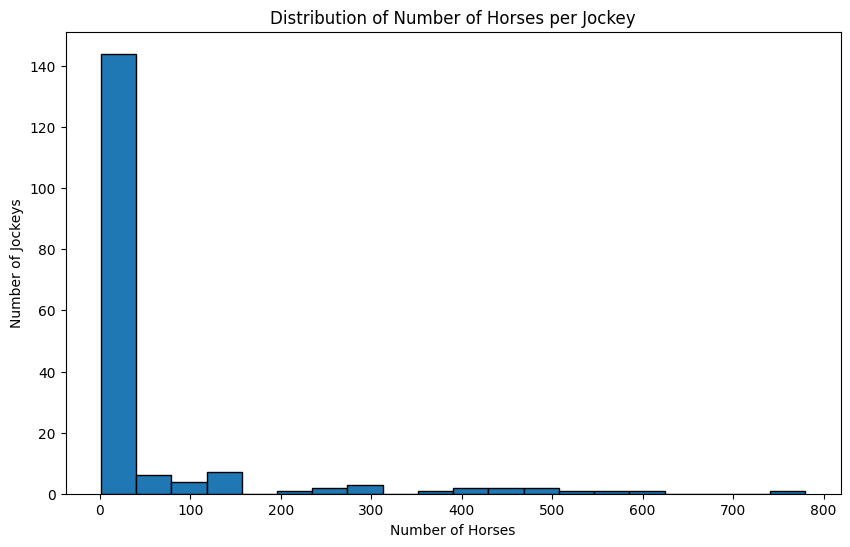

In [35]:
# how many horses do jockeys ride

horses_per_jockey = df.groupby("jockey")["horse_id"].nunique().reset_index()
horses_per_jockey.sort_values("horse_id", ascending=False)
horses_per_jockey["horse_id"].describe()
plt.figure(figsize=(10, 6))
plt.hist(horses_per_jockey["horse_id"], bins=20, edgecolor='black')
plt.title("Distribution of Number of Horses per Jockey")
plt.xlabel("Number of Horses")
plt.ylabel("Number of Jockeys")
plt.show()